# Feature Engineering Product

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('transactions_dataset.csv', sep=";")

In [3]:
df['date_order'] = pd.to_datetime(df['date_order'], format='%Y-%m-%d')

In [4]:
#filtered_df = df.loc[(df['date_order'] >= '2018-01-01') & (df['date_order'] <= '2018-12-31')]
filtered_df = df.copy()

In [5]:
print(filtered_df['date_order'].min())
print(filtered_df['date_order'].max())

2017-09-22 00:00:00
2019-09-22 00:00:00


In [6]:
filtered_df.shape

(63319315, 8)

In [6]:
filtered_df.drop_duplicates()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051
...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015


In [7]:
filtered_df = filtered_df.drop(['date_invoice'],axis=1)

In [8]:
filtered_df = filtered_df.drop(['order_channel'],axis=1)

In [9]:
filtered_df.head()

,date_order,product_id,client_id,sales_net,quantity,branch_id
0,2017-09-25,2376333,188502,155.44320,3,2732
1,2017-09-25,2520527,835089,16.39440,3,10279
2,2017-09-25,2536756,1977896,365.76624,21,6184
3,2017-09-25,3028673,598816,8.59878,201,4200
4,2017-09-25,203377,2086861,1093.37400,3,7051


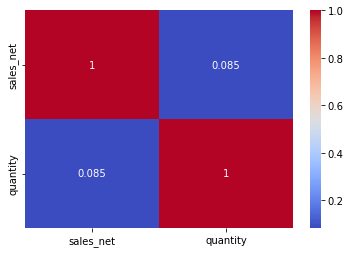

In [10]:
sns.heatmap(data=filtered_df[['date_order', 'sales_net','quantity']].corr(),
            annot=True, cmap='coolwarm');

In [11]:
# Checking for outliers

cols_for_distrib = ['sales_net','quantity',]

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x}: {outlier_function(filtered_df,x)[2]}")

sales_net: 4411763
quantity: 9812964


# Outlier Detection

<AxesSubplot:ylabel='sales_net'>

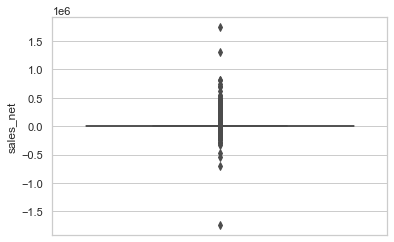

In [12]:
sns.set(style="whitegrid")
sns.boxplot(y=filtered_df['sales_net'])

<AxesSubplot:ylabel='quantity'>

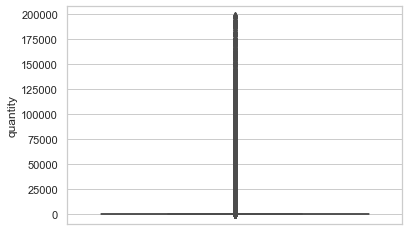

In [13]:
sns.set(style="whitegrid")
sns.boxplot(y=df['quantity'])

# Removing Outliers for sales_net

In [14]:
filtered_df = filtered_df[(filtered_df['sales_net'] > outlier_function(filtered_df,'sales_net')[0]) &
              (filtered_df['sales_net'] < outlier_function(filtered_df,'sales_net')[1])]
filtered_df.head()

,date_order,product_id,client_id,sales_net,quantity,branch_id
0,2017-09-25,2376333,188502,155.44320,3,2732
1,2017-09-25,2520527,835089,16.39440,3,10279
2,2017-09-25,2536756,1977896,365.76624,21,6184
3,2017-09-25,3028673,598816,8.59878,201,4200
5,2017-09-25,793319,564878,116.70384,11,35


In [15]:
filtered_df.shape

(58907546, 6)

In [16]:
filtered_df.nunique()

date_order        731
product_id     411447
client_id      168416
sales_net     1307082
quantity         2329
branch_id         576
dtype: int64

# Defining Churn

In [17]:
#Calculating Recency

df_recency = filtered_df.groupby(by='product_id',
                        as_index=False)['date_order'].max()
df_recency.columns = ['product_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,product_id,LastPurchaseDate,Recency
0,15,2019-09-17,5
1,23,2018-03-08,563
2,39,2019-04-09,166
3,45,2018-11-30,296
4,48,2018-06-12,467


In [18]:
df_recency['I_Recency'] = 1/(df_recency['Recency']+1) #invert the recency as the lower the recency the better 

In [19]:
df_recency.head()

,product_id,LastPurchaseDate,Recency,I_Recency
0,15,2019-09-17,5,0.200000
1,23,2018-03-08,563,0.001776
2,39,2019-04-09,166,0.006024
3,45,2018-11-30,296,0.003378
4,48,2018-06-12,467,0.002141


In [20]:
df_recency.shape

(411447, 4)

In [21]:
#Calculating Frequency
frequency_df = filtered_df.groupby(
    by=['product_id'], as_index=False)['date_order'].nunique()
frequency_df.columns = ['product_id', 'Frequency']
frequency_df.head()

,product_id,Frequency
0,15,70
1,23,2
2,39,1
3,45,1
4,48,1


In [22]:
frequency_df.shape

(411447, 2)

In [23]:
#Calculating Monetary Value
monetary_df = filtered_df.groupby(by='product_id', as_index=False)['sales_net'].sum()
monetary_df.columns = ['product_id', 'Monetary']
monetary_df.head()

,product_id,Monetary
0,15,4161.258652
1,23,613.491267
2,39,197.275600
3,45,59.645808
4,48,391.920000


In [24]:
monetary_df.shape

(411447, 2)

In [25]:
monetary_df['Monetary']=monetary_df['Monetary'].astype('int64')

In [26]:
monetary_df.dtypes

product_id    int64
Monetary      int64
dtype: object

In [27]:
#Merging all three columns in one dataframe
rf_df = df_recency.merge(frequency_df, on='product_id')
rfm_df = rf_df.merge(monetary_df, on='product_id').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,product_id,Recency,I_Recency,Frequency,Monetary
0,15,5,0.200000,70,4161
1,23,563,0.001776,2,613
2,39,166,0.006024,1,197
3,45,296,0.003378,1,59
4,48,467,0.002141,1,391


In [28]:
rfm_table = rfm_df.copy()

In [29]:
#Calculate lifespan
df_lifespam_max = filtered_df.groupby(by='product_id',
                        as_index=False)['date_order'].max()
df_lifespam_max.columns = ['product_id', 'LastPurchaseDate']

In [30]:
df_lifespam_max.head()

,product_id,LastPurchaseDate
0,15,2019-09-17
1,23,2018-03-08
2,39,2019-04-09
3,45,2018-11-30
4,48,2018-06-12


In [31]:
df_lifespam_max.shape

(411447, 2)

In [32]:
df_lifespam_min = filtered_df.groupby(by='product_id',
                        as_index=False)['date_order'].min()
df_lifespam_min.columns = ['product_id', 'FirstPurchaseDate']
df_lifespam_min.head()

,product_id,FirstPurchaseDate
0,15,2019-01-01
1,23,2018-01-22
2,39,2019-04-09
3,45,2018-11-30
4,48,2018-06-12


In [33]:
df_lifespam_min.shape

(411447, 2)

In [34]:
df_lifespam = df_lifespam_max.merge(df_lifespam_min, on='product_id')
df_lifespam.head()

,product_id,LastPurchaseDate,FirstPurchaseDate
0,15,2019-09-17,2019-01-01
1,23,2018-03-08,2018-01-22
2,39,2019-04-09,2019-04-09
3,45,2018-11-30,2018-11-30
4,48,2018-06-12,2018-06-12


In [35]:
df_lifespam.dtypes

product_id                    int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
dtype: object

In [36]:
df_lifespam.shape

(411447, 3)

In [37]:
df_lifespam['lifespam'] = (df_lifespam['LastPurchaseDate'] - df_lifespam['FirstPurchaseDate'])

In [38]:
df_lifespam.head()

,product_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,15,2019-09-17,2019-01-01,259 days
1,23,2018-03-08,2018-01-22,45 days
2,39,2019-04-09,2019-04-09,0 days
3,45,2018-11-30,2018-11-30,0 days
4,48,2018-06-12,2018-06-12,0 days


In [39]:
df_lifespam['lifespam'] = df_lifespam['lifespam'].astype(str)

In [40]:
df_lifespam.head()

,product_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,15,2019-09-17,2019-01-01,259 days
1,23,2018-03-08,2018-01-22,45 days
2,39,2019-04-09,2019-04-09,0 days
3,45,2018-11-30,2018-11-30,0 days
4,48,2018-06-12,2018-06-12,0 days


In [41]:
df_lifespam['lifespam'] = df_lifespam["lifespam"].str.split(" days").str[0].astype(int)

In [42]:
df_lifespam.head()

,product_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,15,2019-09-17,2019-01-01,259
1,23,2018-03-08,2018-01-22,45
2,39,2019-04-09,2019-04-09,0
3,45,2018-11-30,2018-11-30,0
4,48,2018-06-12,2018-06-12,0


In [43]:
df_lifespam.dtypes

product_id                    int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
lifespam                      int32
dtype: object

In [44]:
df_lifespam['lifespam'] = df_lifespam['lifespam'].astype('int64')

In [45]:
df_lifespam.dtypes

product_id                    int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
lifespam                      int64
dtype: object

In [46]:
#Merging all three columns in one dataframe
rfm_lifespam = rfm_df.merge(df_lifespam, on='product_id')
rfm_lifespam.head()

,product_id,Recency,I_Recency,Frequency,Monetary,LastPurchaseDate,FirstPurchaseDate,lifespam
0,15,5,0.200000,70,4161,2019-09-17,2019-01-01,259
1,23,563,0.001776,2,613,2018-03-08,2018-01-22,45
2,39,166,0.006024,1,197,2019-04-09,2019-04-09,0
3,45,296,0.003378,1,59,2018-11-30,2018-11-30,0
4,48,467,0.002141,1,391,2018-06-12,2018-06-12,0


In [47]:
rfm_lifespam.shape

(411447, 8)

In [48]:
rfm_lifespam = rfm_lifespam.drop(['LastPurchaseDate', 'FirstPurchaseDate'], axis=1)
rfm_lifespam.head()

,product_id,Recency,I_Recency,Frequency,Monetary,lifespam
0,15,5,0.200000,70,4161,259
1,23,563,0.001776,2,613,45
2,39,166,0.006024,1,197,0
3,45,296,0.003378,1,59,0
4,48,467,0.002141,1,391,0


In [49]:
rfm_lifespam.shape

(411447, 6)

In [50]:
rfm_lifespam.dtypes

product_id      int64
Recency         int64
I_Recency     float64
Frequency       int64
Monetary        int64
lifespam        int64
dtype: object

In [51]:
#Calculating CLV
clv_df = filtered_df.groupby(by='product_id', as_index=False)['sales_net'].mean()
clv_df.columns = ['product_id', 'monetary_avg']
clv_df.head()

,product_id,monetary_avg
0,15,40.012102
1,23,306.745633
2,39,197.275600
3,45,59.645808
4,48,391.920000


In [52]:
clv_df['monetary_avg']=clv_df['monetary_avg'].astype('int64')
clv_df.dtypes

product_id      int64
monetary_avg    int64
dtype: object

In [53]:
clv_df.shape

(411447, 2)

In [54]:
#Merging all three columns in one dataframe
clv = clv_df.merge(frequency_df, on='product_id')
clv.head()

,product_id,monetary_avg,Frequency
0,15,40,70
1,23,306,2
2,39,197,1
3,45,59,1
4,48,391,1


In [55]:
clv['clv'] = clv['monetary_avg'] * clv['Frequency']
clv.head()

,product_id,monetary_avg,Frequency,clv
0,15,40,70,2800
1,23,306,2,612
2,39,197,1,197
3,45,59,1,59
4,48,391,1,391


In [56]:
clv.shape

(411447, 4)

In [57]:
del clv['Frequency']

In [58]:
clv.head()

,product_id,monetary_avg,clv
0,15,40,2800
1,23,306,612
2,39,197,197
3,45,59,59
4,48,391,391


In [59]:
rfm = rfm_lifespam.merge(clv, on='product_id')
rfm.head()

,product_id,Recency,I_Recency,Frequency,Monetary,lifespam,monetary_avg,clv
0,15,5,0.200000,70,4161,259,40,2800
1,23,563,0.001776,2,613,45,306,612
2,39,166,0.006024,1,197,0,197,197
3,45,296,0.003378,1,59,0,59,59
4,48,467,0.002141,1,391,0,391,391


In [60]:
del rfm['monetary_avg']

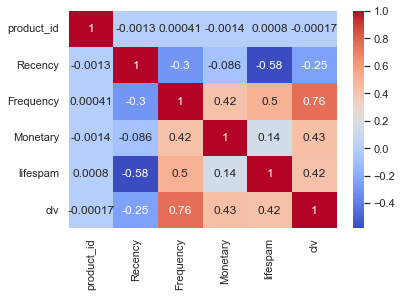

In [61]:
sns.heatmap(data=rfm[['product_id', 'Recency','Frequency','Monetary','lifespam','clv']].corr(),
            annot=True, cmap='coolwarm');

In [62]:
rfm1 = rfm.copy()

In [63]:
# Dropping Frequency column

del rfm1['Frequency']

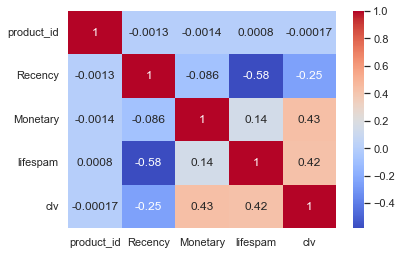

In [64]:
sns.heatmap(data=rfm[['product_id', 'Recency','Monetary','lifespam','clv']].corr(),
            annot=True, cmap='coolwarm');

In [65]:
# Checking for outliers

cols_for_distrib = ['product_id', 'Recency','Monetary','lifespam','clv']

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x}: {outlier_function(rfm1,x)[2]}")

product_id: 0
Recency: 0
Monetary: 55498
lifespam: 0
clv: 52937


<AxesSubplot:ylabel='Monetary'>

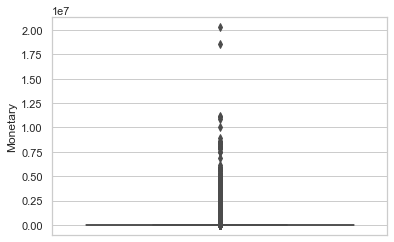

In [66]:
sns.set(style="whitegrid")
sns.boxplot(y=rfm1['Monetary'])

<AxesSubplot:ylabel='clv'>

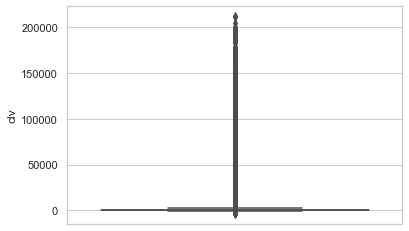

In [67]:
sns.set(style="whitegrid")
sns.boxplot(y=rfm1['clv'])

<AxesSubplot:xlabel='lifespam', ylabel='clv'>

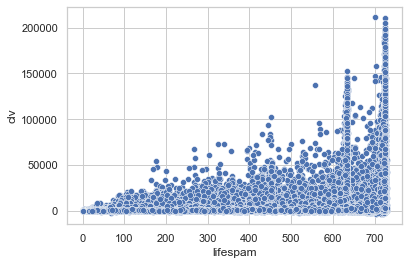

In [68]:
sns.scatterplot(x=rfm1['lifespam'], y=rfm1['clv'])

<AxesSubplot:xlabel='Monetary', ylabel='clv'>

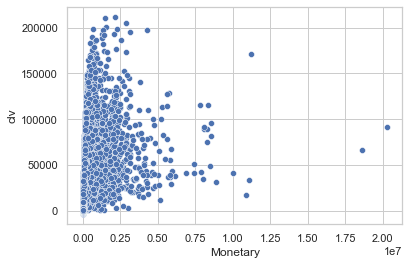

In [69]:
sns.scatterplot(x=rfm1['Monetary'], y=rfm1['clv'])

In [70]:
rfm1 = rfm1[(rfm1['Monetary'] > outlier_function(rfm1,'Monetary')[0]) &
              (rfm1['Monetary'] < outlier_function(rfm1,'Monetary')[1])]
rfm1.head()

,product_id,Recency,I_Recency,Monetary,lifespam,clv
1,23,563,0.001776,613,45,612
2,39,166,0.006024,197,0,197
3,45,296,0.003378,59,0,59
4,48,467,0.002141,391,0,391
7,96,418,0.002392,191,0,191


In [71]:
rfm1.shape

(355942, 6)

<AxesSubplot:xlabel='Monetary', ylabel='clv'>

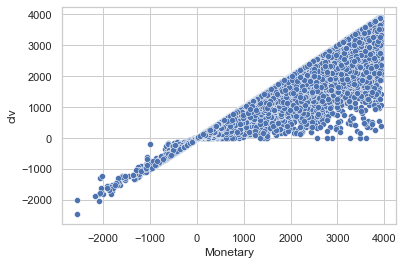

In [72]:
sns.scatterplot(x=rfm1['Monetary'], y=rfm1['clv'])

# Defining Churn

In [73]:
print(rfm1.clv.mean(),
rfm1.clv.median(),
rfm1.clv.quantile(0.25),
rfm1.clv.quantile(0.5), 
rfm1.clv.quantile(0.75))

440.02713925302436 231.0 87.0 231.0 461.0


In [74]:
def score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    if x <= d[p][0.5] and x >d[p][0.25]:
        return 2
    if x <= d[p][0.75] and x >d[p][0.5]: 
        return 3
    if x >d[p][0.75]:
        return 4

In [75]:
quantiles = rfm1.quantile(q=[0.25,0.50,0.75])
quantiles

,product_id,Recency,I_Recency,Monetary,lifespam,clv
0.25,813668.0,75.0,0.002203,92.0,0.0,87.0
0.50,1626423.5,242.0,0.004132,244.0,0.0,231.0
0.75,2433423.5,454.0,0.013333,481.0,284.0,461.0


In [76]:
quantiles = quantiles.to_dict()
rfm1['clv_Tile'] = rfm1['clv'].apply(score, args=('clv',quantiles))

In [77]:
rfm1['clv_Tile'].value_counts()

1    89341
3    88971
4    88889
2    88741
Name: clv_Tile, dtype: int64

In [78]:
def score_recency(x,p,d):
    if x <= d[p][0.25]:
        return 4
    if x <= d[p][0.5] and x >d[p][0.25]:
        return 3
    if x <= d[p][0.75] and x >d[p][0.5]: 
        return 2
    if x >d[p][0.75]:
        return 1

In [79]:
rfm1['Rec_Tile'] = rfm1['Recency'].apply(score_recency, args=('Recency',quantiles,))

In [80]:
rfm1['Rec_Tile'].value_counts()

4    89241
3    89098
1    88862
2    88741
Name: Rec_Tile, dtype: int64

In [82]:
rfm1['I_Rec_Tile'] = rfm1['I_Recency'].apply(score, args=('I_Recency',quantiles,))

In [83]:
rfm1['I_Rec_Tile'].value_counts()

3    89596
1    89551
2    88738
4    88057
Name: I_Rec_Tile, dtype: int64

In [84]:
rfm1['Mone_Tile'] = rfm1['Monetary'].apply(score, args=('Monetary',quantiles,))
rfm1['Mone_Tile'].value_counts()

1    89408
3    88939
4    88815
2    88780
Name: Mone_Tile, dtype: int64

In [85]:
rfm1['lifespam_Tile'] = rfm1['lifespam'].apply(score, args=('lifespam',quantiles,))
rfm1['lifespam_Tile'].value_counts()

1    207812
4     88876
3     59254
Name: lifespam_Tile, dtype: int64

In [86]:
# Add to dataframe
rfm1['score_v1'] = rfm1['clv_Tile'].map(str) + rfm1['Rec_Tile'].map(str) + rfm1['Mone_Tile'].map(str) + rfm1['lifespam_Tile'].map(str)
rfm1.head()

,product_id,Recency,I_Recency,Monetary,lifespam,clv,clv_Tile,Rec_Tile,I_Rec_Tile,Mone_Tile,lifespam_Tile,score_v1
1,23,563,0.001776,613,45,612,4,1,1,4,3,4143
2,39,166,0.006024,197,0,197,2,3,3,2,1,2321
3,45,296,0.003378,59,0,59,1,2,2,1,1,1211
4,48,467,0.002141,391,0,391,3,1,1,3,1,3131
7,96,418,0.002392,191,0,191,2,2,2,2,1,2221


In [87]:
rfm1.score_v1.min()

'1111'

In [88]:
#Who are the lost customers?

#Customers who's recency, frequency as well as monetary values are low 

rfm1[rfm1['score_v1'] == '1111'].sort_values('Recency',ascending=False).count()

product_id       26239
Recency          26239
I_Recency        26239
Monetary         26239
lifespam         26239
clv              26239
clv_Tile         26239
Rec_Tile         26239
I_Rec_Tile       26239
Mone_Tile        26239
lifespam_Tile    26239
score_v1         26239
dtype: int64

In [89]:
#Summing the RFM Score
rfm1['score'] = rfm1[['clv_Tile','Rec_Tile','Mone_Tile','lifespam_Tile']].sum(axis=1)
rfm1.head()

,product_id,Recency,I_Recency,Monetary,lifespam,clv,clv_Tile,Rec_Tile,I_Rec_Tile,Mone_Tile,lifespam_Tile,score_v1,score
1,23,563,0.001776,613,45,612,4,1,1,4,3,4143,12
2,39,166,0.006024,197,0,197,2,3,3,2,1,2321,8
3,45,296,0.003378,59,0,59,1,2,2,1,1,1211,5
4,48,467,0.002141,391,0,391,3,1,1,3,1,3131,8
7,96,418,0.002392,191,0,191,2,2,2,2,1,2221,7


In [90]:
print(rfm1.score.mean(),
rfm1.score.median(),
rfm1.score.max(),
rfm1.score.min(),     
rfm1.score.quantile(0.25),
rfm1.score.quantile(0.5), 
rfm1.score.quantile(0.75))

9.580260267122172 9.0 16 4 6.0 9.0 13.0


In [91]:
rfm1.score.value_counts()

8     42728
6     41473
9     36239
7     33716
16    31774
15    31711
4     26239
10    24746
5     22366
11    19082
14    16907
13    14765
12    14196
Name: score, dtype: int64

In [92]:
def score_level(df):
    if df['score']<=7:
        return 'Churned'
    if df['score'] >7 and df['score'] <=10:
        return 'Regular'
    if df['score'] >10 and df['score'] <=13:
        return 'Loyal'
    if df['score'] >13:
        return 'Premium'

In [93]:
# Create a new variable RFM_Level
rfm1['score_level'] = rfm1.apply(score_level, axis=1)

# Print the header with top 5 rows to the console
rfm1.head()

,product_id,Recency,I_Recency,Monetary,lifespam,clv,clv_Tile,Rec_Tile,I_Rec_Tile,Mone_Tile,lifespam_Tile,score_v1,score,score_level
1,23,563,0.001776,613,45,612,4,1,1,4,3,4143,12,Loyal
2,39,166,0.006024,197,0,197,2,3,3,2,1,2321,8,Regular
3,45,296,0.003378,59,0,59,1,2,2,1,1,1211,5,Churned
4,48,467,0.002141,391,0,391,3,1,1,3,1,3131,8,Regular
7,96,418,0.002392,191,0,191,2,2,2,2,1,2221,7,Churned


In [94]:
rfm1.to_csv('product_clustering_2.csv', sep=',', index = False)

In [95]:
rfm1["score_level"].value_counts()

Churned    123794
Regular    103713
Premium     80392
Loyal       48043
Name: score_level, dtype: int64

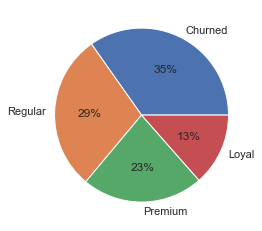

In [96]:
plt.pie(rfm1.score_level.value_counts(),
        labels=rfm1.score_level.value_counts().index,
        autopct='%.0f%%')
plt.show()